In [1]:
pip install z3-solver

Note: you may need to restart the kernel to use updated packages.


In [2]:
from z3 import *
import math
import time
import itertools
import io
from datetime import datetime
import numpy as np


In [3]:
import sys 
sys.path.append('../../')
from utils.utils import * 

In [4]:
def pack_rectangles(timeout, max_width, lowerbound, H_UB, number_rectangles, width,height,rotation,symmetry, verbose = False):

    #start_time = time.time()
   
    s = Optimize()
    s.set("timeout", timeout * 1000)
    
    
    circuits_x = [Int(f"x_{i}") for i in range(number_rectangles)]
    circuits_y = [Int(f"y_{i}") for i in range(number_rectangles)]
    circuits_w,circuits_h=width,height
    
    #computing upperbound
    xx=circuits_x.copy()
    yy=circuits_y.copy()  
    W =max_width
    upperbound = H_UB
    
    Rectangle_height = Int('Rectangle_height')
    s.add(Rectangle_height <= upperbound)
    s.add(Rectangle_height >= lowerbound)
    

   
    Circuits_w = [Int(f"w_{i}") for i in range(number_rectangles)]
    Circuits_h = [Int(f"h_{i}") for i in range(number_rectangles)]
    rotation = [Bool(f"rotation_{i}") for i in range(number_rectangles)]

    if rotation:
        s.add([Or(And(Not(rotation[i]), Circuits_w[i] == width[i], Circuits_h[i] == height[i]), And(rotation[i],Circuits_w[i] == height[i], Circuits_h[i] == width[i])) for i in range(number_rectangles)])
    else:
        s.add([And(Circuits_w[i] == width[i], Circuits_h[i] == height[i]) for i in range(number_rectangles)])     
               
        
    H = lowerbound    
           
    non_overlap = [Or( 
                    circuits_x[i] + circuits_w[i] <= circuits_x[j],
                    circuits_x[i] >= circuits_x[j] + circuits_w[j],
                    circuits_y[i] + circuits_h[i] <= circuits_y[j],
                    circuits_y[i] >= circuits_y[j] + circuits_h[j]
                    ) for i in range(number_rectangles-1) for j in range(i+1, number_rectangles)]
    
    in_limits = [And(circuits_x[i] + circuits_w[i] <= max_width,
                circuits_y[i] + circuits_h[i] <= Rectangle_height, 
                circuits_x[i] >= 0, 
                circuits_y[i] >= 0) for i in range(number_rectangles)]
    
    
    
    if symmetry:
        # symmetry breaking constraints
        for i in range(number_rectangles):
            for j in range(number_rectangles):
                if i != j:


                    #symmetry breaking constraint         
                    s.add(Implies(circuits_w[i] + circuits_w[j] > W,And(circuits_x[i]+circuits_w[i]>circuits_x[j],circuits_x[j]+circuits_w[j]>circuits_x[i])))
                    s.add(Implies(circuits_h[i] + circuits_h[j] > H,And(circuits_y[i]+circuits_h[i]>circuits_y[j],circuits_y[j]+circuits_h[j]>circuits_y[i])))
    
    
    s.add(non_overlap + in_limits)
    
    s.minimize(Rectangle_height)

    

    if not(s.check() == sat):
        if verbose:
            print('UNSAT')
        return True,-1,-1,301

    
    if verbose:
        print(f'Solved in time:{s.statistics().time} s')
    
    model = s.model()
    
    x = [model.__getitem__(i).as_long() for i in circuits_x]
    y = [model.__getitem__(i).as_long() for i in circuits_y]
    time = s.statistics().time
    rot = [model.__getitem__(i) for i in rotation] #FIXME in bool
    
    return False, x, y, time, rot 
"""

for i in range(1,5):
    file_name = "./../instances/ins-" + str(i) + ".txt"
    file = open(file_name)
    max_width = int(file.readline())
    number_rectangles = int(file.readline())

    width = []
    height = []

    for line in file:
        width_height = line.split()
        width_height = [int(x) for x in width_height]
        width.append(width_height[0])
        height.append(width_height[1])

    dimension_rectangle = []
    for j, k in zip(width, height):
        dimension_rectangle.append([j, k])

    area = sum([b[0] * b[1] for b in dimension_rectangle])
    lowerbound = area / max_width
    circuits_w,circuits_h=width,height
    

    start = time.time()
    s, px, py,z_time = pack_rectangles(max_width,number_rectangles,width,height,False, False)
    end = time.time()
    
    final_time = end - start

    if s != -1:
        m = s.model()
        file_out = "./../out_test/out-" + str(i) + ".txt"
        file_out_time_1 = "./../time_test/time-" + str(i) + ".txt"

        with open(file_out, 'w') as file:

            result = sorted([(d, m[d]) for d in m], key=lambda x: str(x[0]))
            file.write(str(max_width) + ' ' + str(lowerbound) + "\n")
            file.write(str(number_rectangles)+'\n')
            for k in range(1,number_rectangles+1):
                file.write(str(width[k-1]) + ' ' + str(height[k-1]) + ' ' + str(m.evaluate(px[k-1])) + ' ' + str(m.evaluate(py[k-1])) + "\n")


        with open(file_out_time_1, 'w') as file:
            file.write(str(final_time))
             
    else:
        
        file_out_time_1 = "./../time_test_UN/time-" + str(i) + ".txt"
        
        with open(file_out_time_1, 'w') as file:
            
            file.write(str(final_time))
"""    

'\n\nfor i in range(1,5):\n    file_name = "./../instances/ins-" + str(i) + ".txt"\n    file = open(file_name)\n    max_width = int(file.readline())\n    number_rectangles = int(file.readline())\n\n    width = []\n    height = []\n\n    for line in file:\n        width_height = line.split()\n        width_height = [int(x) for x in width_height]\n        width.append(width_height[0])\n        height.append(width_height[1])\n\n    dimension_rectangle = []\n    for j, k in zip(width, height):\n        dimension_rectangle.append([j, k])\n\n    area = sum([b[0] * b[1] for b in dimension_rectangle])\n    lowerbound = area / max_width\n    circuits_w,circuits_h=width,height\n    \n\n    start = time.time()\n    s, px, py,z_time = pack_rectangles(max_width,number_rectangles,width,height,False, False)\n    end = time.time()\n    \n    final_time = end - start\n\n    if s != -1:\n        m = s.model()\n        file_out = "./../out_test/out-" + str(i) + ".txt"\n        file_out_time_1 = "./../tim

In [5]:
"""
from os import listdir
from os.path import isfile, join
onlyfiles_1 = [f for f in listdir(r"./../time_1_all/") if isfile(join("./../time_1_all/", f))]
onlyfiles_1_r = [f for f in listdir(r"./../time_1_r_all/") if isfile(join("./../time_1_r_all/", f))]

'''
onlyfiles_2 = [f for f in listdir("./../time_2_all/") if isfile(join("./../time_2_all/", f))]
onlyfiles_2_r = [f for f in listdir("./../time_2_r_all/") if isfile(join("./../time_2_r_all/", f))]
'''

times_1_all=[]
times_1_r_all=[]
times_2_all=[]
times_2_r_all=[]

for i in range(1,41):
    with open(r"./../time_1_all/time-" + str(i)+".txt") as f:
        lines = f.readlines()
        times_1_all.append(float(lines[0]))


for i in range(1,41):
    with open(r"./../time_1_r_all/time-" + str(i)+".txt") as f:
        lines = f.readlines()
        times_1_r_all.append(float(lines[0]))



for i in range(1,41):
    with open(r"./../time_2_all/time-" + str(i)+".txt") as f:
        lines = f.readlines()
        times_2_all.append(float(lines[0]))
        

for i in range(1,41):
    with open(r"./../time_2_r_all/time-" + str(i)+".txt") as f:
        lines = f.readlines()
        times_2_r_all.append(float(lines[0]))


"""

'\nfrom os import listdir\nfrom os.path import isfile, join\nonlyfiles_1 = [f for f in listdir(r"./../time_1_all/") if isfile(join("./../time_1_all/", f))]\nonlyfiles_1_r = [f for f in listdir(r"./../time_1_r_all/") if isfile(join("./../time_1_r_all/", f))]\n\n\'\'\'\nonlyfiles_2 = [f for f in listdir("./../time_2_all/") if isfile(join("./../time_2_all/", f))]\nonlyfiles_2_r = [f for f in listdir("./../time_2_r_all/") if isfile(join("./../time_2_r_all/", f))]\n\'\'\'\n\ntimes_1_all=[]\ntimes_1_r_all=[]\ntimes_2_all=[]\ntimes_2_r_all=[]\n\nfor i in range(1,41):\n    with open(r"./../time_1_all/time-" + str(i)+".txt") as f:\n        lines = f.readlines()\n        times_1_all.append(float(lines[0]))\n\n\nfor i in range(1,41):\n    with open(r"./../time_1_r_all/time-" + str(i)+".txt") as f:\n        lines = f.readlines()\n        times_1_r_all.append(float(lines[0]))\n\n\n\nfor i in range(1,41):\n    with open(r"./../time_2_all/time-" + str(i)+".txt") as f:\n        lines = f.readlines()\n

In [6]:
"""
import matplotlib.pyplot as plt
import numpy as np


# make data:

#x = [i for i in range(1,len(times)+1)]
x=np.arange(len(times_1_all))


#N=len(times)

# plot
fig,ax = plt.subplots()

plt.ylabel('Time (s)')
plt.xlabel('instance files')
#plt.bar(x, times_1, width=0.7, edgecolor="white", linewidth=0.7)
#plt.bar(x, times_1_r, width=0.5, edgecolor="red", linewidth=0.7)
color_1=[]
color_1_r=[]
for i,j in zip( times_1_all,times_1_r_all):
    if i<=300:
        color_1.append('#0000FF')
    else:
        color_1.append('#ADD8E6')
    if j<300:
        color_1_r.append('#FF8C00')
    else:
        color_1_r.append('#FFD580')

plt.bar(x -0.2 , times_1_all, 0.4, color= color_1 ,label = 'Basic Time')
plt.bar(x +0.2, times_1_r_all, 0.4,color= color_1_r , label = 'Rotated Time')
plt.yscale("log")
ax.grid(zorder=0)
plt.title("VLSI SMT Benchmark")
plt.legend(loc='best')
plt.savefig('../graphs/basic.png')
plt.show()
"""

'\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n\n# make data:\n\n#x = [i for i in range(1,len(times)+1)]\nx=np.arange(len(times_1_all))\n\n\n#N=len(times)\n\n# plot\nfig,ax = plt.subplots()\n\nplt.ylabel(\'Time (s)\')\nplt.xlabel(\'instance files\')\n#plt.bar(x, times_1, width=0.7, edgecolor="white", linewidth=0.7)\n#plt.bar(x, times_1_r, width=0.5, edgecolor="red", linewidth=0.7)\ncolor_1=[]\ncolor_1_r=[]\nfor i,j in zip( times_1_all,times_1_r_all):\n    if i<=300:\n        color_1.append(\'#0000FF\')\n    else:\n        color_1.append(\'#ADD8E6\')\n    if j<300:\n        color_1_r.append(\'#FF8C00\')\n    else:\n        color_1_r.append(\'#FFD580\')\n\nplt.bar(x -0.2 , times_1_all, 0.4, color= color_1 ,label = \'Basic Time\')\nplt.bar(x +0.2, times_1_r_all, 0.4,color= color_1_r , label = \'Rotated Time\')\nplt.yscale("log")\nax.grid(zorder=0)\nplt.title("VLSI SMT Benchmark")\nplt.legend(loc=\'best\')\nplt.savefig(\'../graphs/basic.png\')\nplt.show()\n'

In [7]:
'''

# make data:

#x = [i for i in range(1,len(times)+1)]
x=np.arange(len(times_2_all))



# plot
fig,ax = plt.subplots()

plt.ylabel('Time (s)')
plt.xlabel('instance files')
#plt.bar(x, times_1, width=0.7, edgecolor="white", linewidth=0.7)
#plt.bar(x, times_1_r, width=0.5, edgecolor="red", linewidth=0.7)
color_2=[]
color_2_r=[]
for i,j in zip( times_2_all,times_2_r_all):
    if i<=300:
        color_2.append('#0000FF')
    else:
        color_2.append('#ADD8E6')
    if j<=300:
        color_2_r.append('#FF8C00')
    else:
        color_2_r.append('#FFD580')

plt.bar(x -0.2 , times_2_all, 0.4, color= color_2 ,label = 'SB Time')
plt.bar(x +0.2, times_2_r_all, 0.4,color= color_2_r , label = 'SB Rotated Time')
plt.yscale("log")
ax.grid(zorder=0)
plt.title("VLSI SMT Benchmark")
plt.legend(loc='best')
plt.savefig('../graphs/symmetry.png')
plt.show()
'''

'\n\n# make data:\n\n#x = [i for i in range(1,len(times)+1)]\nx=np.arange(len(times_2_all))\n\n\n\n# plot\nfig,ax = plt.subplots()\n\nplt.ylabel(\'Time (s)\')\nplt.xlabel(\'instance files\')\n#plt.bar(x, times_1, width=0.7, edgecolor="white", linewidth=0.7)\n#plt.bar(x, times_1_r, width=0.5, edgecolor="red", linewidth=0.7)\ncolor_2=[]\ncolor_2_r=[]\nfor i,j in zip( times_2_all,times_2_r_all):\n    if i<=300:\n        color_2.append(\'#0000FF\')\n    else:\n        color_2.append(\'#ADD8E6\')\n    if j<=300:\n        color_2_r.append(\'#FF8C00\')\n    else:\n        color_2_r.append(\'#FFD580\')\n\nplt.bar(x -0.2 , times_2_all, 0.4, color= color_2 ,label = \'SB Time\')\nplt.bar(x +0.2, times_2_r_all, 0.4,color= color_2_r , label = \'SB Rotated Time\')\nplt.yscale("log")\nax.grid(zorder=0)\nplt.title("VLSI SMT Benchmark")\nplt.legend(loc=\'best\')\nplt.savefig(\'../graphs/symmetry.png\')\nplt.show()\n'

In [8]:
'''
color_2=[]
color_2_r=[]
for i,j in zip( times_2_all,times_2_r_all):
    if i<=300:
        color_2.append('#A020F0')
    else:
        color_2.append('#CF9FFF')
    if j<=300:
        color_2_r.append('#00FF00')
    else:
        color_2_r.append('#90EE90')
plt.bar(x -0.6 , times_2_all, 0.4, color= color_2 ,label = 'SB Time')
plt.bar(x +0.6, times_2_r_all, 0.4,color= color_2_r , label = 'SB Rotated Time')
plt.bar(x -0.2 , times_1_all, 0.4, color= color_1 ,label = 'Basic Time')
plt.bar(x +0.2, times_1_r_all, 0.4,color= color_1_r , label = 'Rotated Time')
plt.yscale("log")
plt.legend(loc='best')
plt.show()
'''

'\ncolor_2=[]\ncolor_2_r=[]\nfor i,j in zip( times_2_all,times_2_r_all):\n    if i<=300:\n        color_2.append(\'#A020F0\')\n    else:\n        color_2.append(\'#CF9FFF\')\n    if j<=300:\n        color_2_r.append(\'#00FF00\')\n    else:\n        color_2_r.append(\'#90EE90\')\nplt.bar(x -0.6 , times_2_all, 0.4, color= color_2 ,label = \'SB Time\')\nplt.bar(x +0.6, times_2_r_all, 0.4,color= color_2_r , label = \'SB Rotated Time\')\nplt.bar(x -0.2 , times_1_all, 0.4, color= color_1 ,label = \'Basic Time\')\nplt.bar(x +0.2, times_1_r_all, 0.4,color= color_1_r , label = \'Rotated Time\')\nplt.yscale("log")\nplt.legend(loc=\'best\')\nplt.show()\n'

  0%|                                                                                                                                                | 0/5 [00:00<?, ?it/s]

[None, False, True, None]


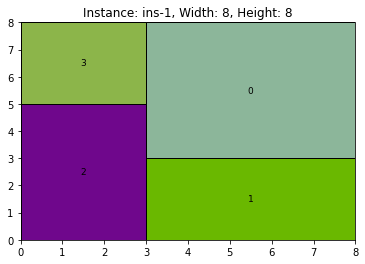

[None, False, False, None]


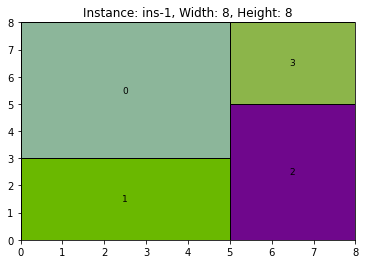

[None, True, False, None]


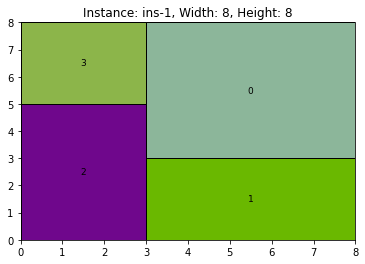

[None, False, False, None]


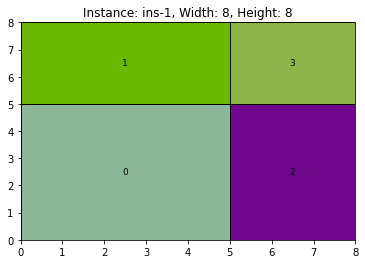

 20%|███████████████████████████▏                                                                                                            | 1/5 [00:03<00:12,  3.19s/it]

[False, False, True, True, None]


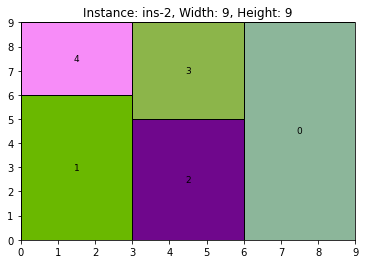

[False, True, False, True, None]


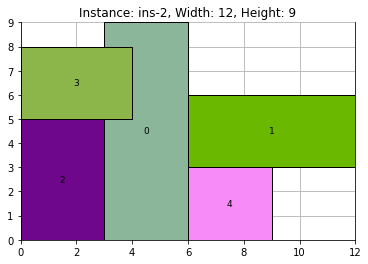

[True, False, True, True, None]


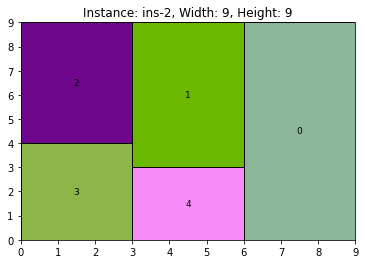

[False, False, True, False, None]


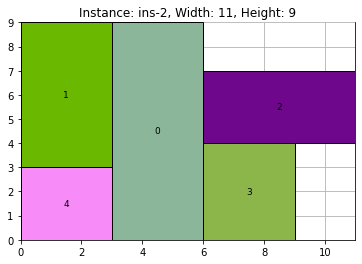

 40%|██████████████████████████████████████████████████████▍                                                                                 | 2/5 [00:06<00:09,  3.11s/it]

[False, None, True, False, True, None]


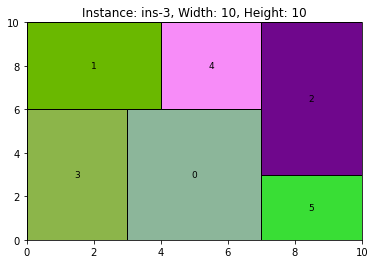

[False, None, False, False, False, None]


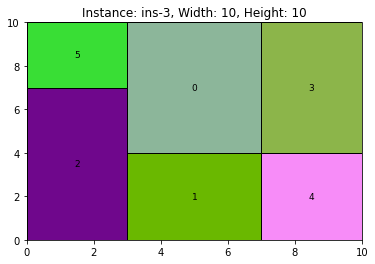

[False, None, True, True, True, None]


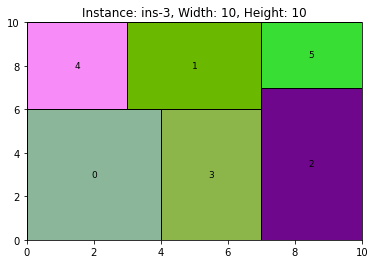

[False, None, False, True, False, None]


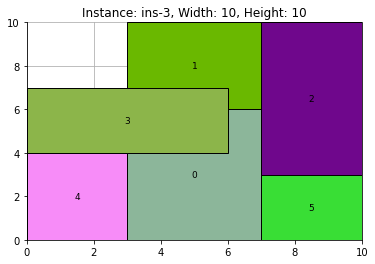

 60%|█████████████████████████████████████████████████████████████████████████████████▌                                                      | 3/5 [00:08<00:05,  2.76s/it]

[False, True, True, True, True, True, None]


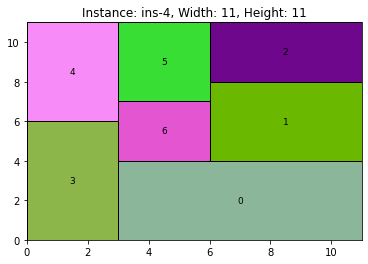

[True, True, True, False, True, False, None]


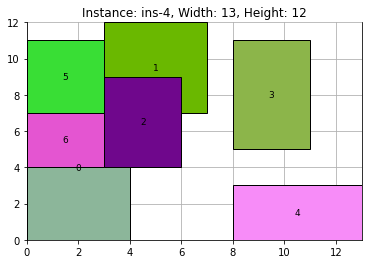

[True, True, False, False, False, False, None]


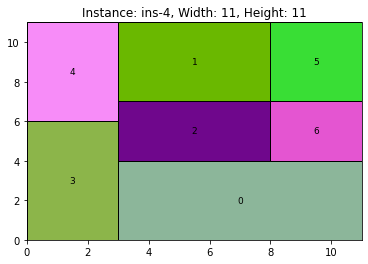

[True, True, False, False, False, False, None]


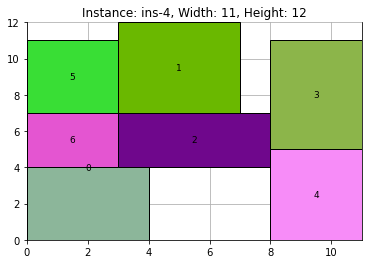

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4/5 [00:11<00:02,  2.78s/it]

[False, True, True, True, True, False, True, None]


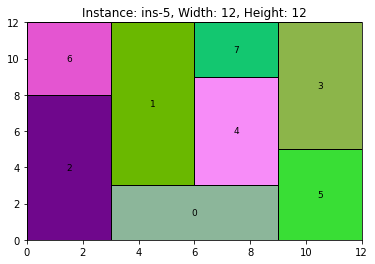

[False, True, False, False, True, True, False, None]


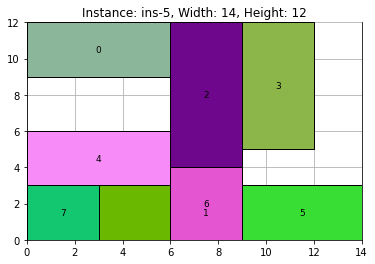

[False, True, False, True, False, False, False, None]


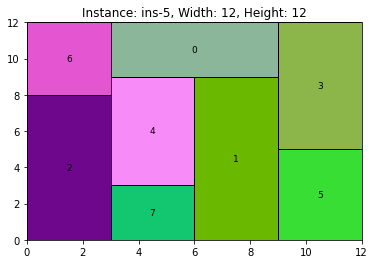

[False, True, True, True, False, False, True, None]


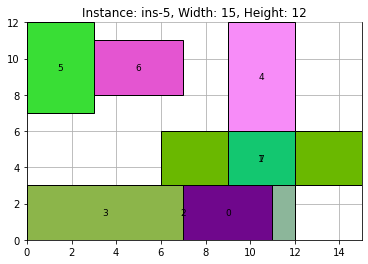

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.94s/it]


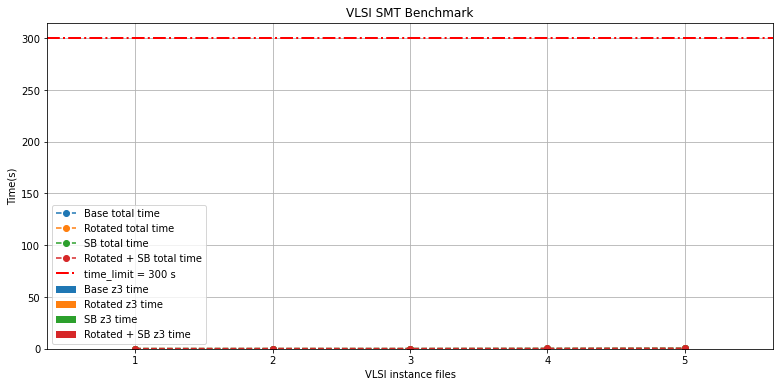

total Base time        -- mean: 0.186644983291626 std: 0.07185439055147866 
total rotated time     -- mean: 0.19558300971984863 std: 0.06268724209802558 
total SB time          -- mean: 0.2795101642608643 std: 0.08617100342081947 
total rotated + SB time-- mean: 0.28365530967712405 std: 0.09720114201639705 
z3 Base time           -- mean: 0.0432 std: 0.03945326348985594 
z3 rotated time        -- mean: 0.0468 std: 0.04475444112040726 
z3 SB time             -- mean: 0.052000000000000005 std: 0.03837186469276676 
z3 rotated + SB time   -- mean: 0.027600000000000003 std: 0.014347125147568763


In [9]:
import time
from tqdm import tqdm

def smt_benchmark(index, timeout, method, verbose = False, plot = False):
    
    if method == "base":
        rotations = False
        symmetry_breaking = False
    
    if method == "base-sb":
        rotations = False
        symmetry_breaking = True
    
    if method == "rotations":
        rotations = True
        symmetry_breaking = False
    
    if method == "rotations-sb":
        rotations = True
        symmetry_breaking = True
        
    folder = "../../instances/"
    file = f"ins-{index}.txt"
    url = folder + file
    instance = VLSI_Instance(path=url, order_by_width = True)
    widths, heights = instance.get_width_height()
    
    start = time.time()
    time_over, px, py, z3_time, rotated = pack_rectangles(timeout, instance.W, instance.H_LB(), instance.H_UB_BL(), instance.n_instances, widths, heights, rotations, symmetry_breaking, verbose)
    end = time.time()
    
    rectangles = instance.rectangles

    print(rotated)
    
    for i in range(instance.n_instances):

        rectangles[i].x = px[i]
        rectangles[i].y = py[i]
        

        if rotations and rotated[i]:
            width = rectangles[i].width
            height = rectangles[i].height
            rectangles[i].height = width 
            rectangles[i].width = height
    
    instance.H = max([(rect.y + rect.height) for rect in rectangles])
    
    
    path = method
    
    solve_time = (end - start)
    
    write_log(path="../../out/smt/" + path + "/" + file, instance = instance, 
              add_text="\n" + str(solve_time) + "\n" + str(time_over))
    
    if plot:
        plot_rectangles(rectangles, title=file, indexes=True)
    
    return solve_time, time_over, z3_time

def plot_SMT_benchmark(instances_to_solve = 5,timeout = 300, plot=False, verbose=False):
    '''
    Plotting the barplot with all the SMT solving mechanisms (base, rotated, 
    base + symmetry breaking, rotated + symmetry breaking)
    '''

    times_base = []
    times_base_rotate = []
    times_SB = []
    times_SB_rotate = []

    z3_times_base = []
    z3_times_base_rotate = []
    z3_times_SB = []
    z3_times_SB_rotate = []

    time_overs_base = []
    time_overs_base_rotate = []
    time_overs_SB = []
    time_overs_SB_rotate = []
    
    for i in tqdm(range(1, instances_to_solve + 1)):
        timer, time_over, z3_timer = smt_benchmark(i, timeout, "base-sb", verbose = verbose, plot = plot)
        times_SB.append(timer)
        z3_times_SB.append(z3_timer)

        if(time_over):
            time_overs_SB.append(i-1)


        timer, time_over, z3_timer =  smt_benchmark(i, timeout, "rotations-sb", verbose = verbose, plot = plot)
        times_SB_rotate.append(timer)
        z3_times_SB_rotate.append(z3_timer)

        if(time_over):
            time_overs_SB_rotate.append(i-1)

        url = f"../instances/ins-{i}.txt"
        timer, time_over, z3_timer = smt_benchmark(i, timeout, "base", verbose = verbose, plot = plot)
        times_base.append(timer)
        z3_times_base.append(z3_timer)

        if(time_over):
            time_overs_base.append(i-1)

        url = f"../instances/ins-{i}.txt"
        timer, time_over, z3_timer = smt_benchmark(i, timeout, "rotations", verbose = verbose, plot = plot)
        times_base_rotate.append(timer)
        z3_times_base_rotate.append(z3_timer)

        if(time_over):
            time_overs_base_rotate.append(i-1)

    X = range(1, instances_to_solve + 1) 
    X_axis = np.arange(0,len(times_SB)*2,2)


    plt.rcParams["figure.figsize"] = (13,6)
    plt.xticks(X_axis, X)



    # base z3
    barbase = plt.bar(X_axis - 0.6, z3_times_base, 0.4, label = 'Base z3 time')
  
    # base total
    plt.plot(X_axis, times_base, linestyle='--', marker='o', label='Base total time')

    for i in time_overs_base:  
        barbase[i].set_alpha(0.25)
  
    # base + rotation z3
    barbaserotation = plt.bar(X_axis - 0.2, z3_times_base_rotate, 0.4, label = 'Rotated z3 time')
  
    # base + rotation total
    plt.plot(X_axis, times_base_rotate, linestyle='--', marker='o', label='Rotated total time')

    for i in time_overs_base_rotate:
        barbaserotation[i].set_alpha(0.25)

    # SB
    barSB = plt.bar(X_axis + 0.2, z3_times_SB, 0.4, label = 'SB z3 time')
  
    # SB total
    plt.plot(X_axis, times_SB, linestyle='--', marker='o', label='SB total time')

    for i in time_overs_SB:  
        barSB[i].set_alpha(0.25)
        
    # SB + rotation
    barSBrotation = plt.bar(X_axis + 0.6, z3_times_SB_rotate, 0.4, label = 'Rotated + SB z3 time')

    #SB + rotation total
    plt.plot(X_axis, times_SB_rotate, linestyle='--', marker='o', label='Rotated + SB total time')

    for i in time_overs_SB_rotate:  
        barSBrotation[i].set_alpha(0.25)

    plt.xlabel("VLSI instance files")
    plt.ylabel("Time(s)")
    plt.title("VLSI SMT Benchmark")
    plt.grid()
    plt.axhline(y=timeout, xmin=0, xmax=1, color='r', linestyle='-.', linewidth=2, label=f"time_limit = {timeout} s")
    #plt.yscale("log")
    plt.legend()
    plt.savefig('smt_benchmark.png', transparent=False,format="png")
    plt.show()

    out_text= ""

    out_text += f"total Base time        -- mean: {np.mean(times_base)} std: {np.std(times_base)} \n"
    out_text += f"total rotated time     -- mean: {np.mean(times_base_rotate)} std: {np.std(times_base_rotate)} \n"
    out_text += f"total SB time          -- mean: {np.mean(times_SB)} std: {np.std(times_SB)} \n"
    out_text += f"total rotated + SB time-- mean: {np.mean(times_SB_rotate)} std: {np.std(times_SB_rotate)} \n"

    out_text += f"z3 Base time           -- mean: {np.mean(z3_times_base)} std: {np.std(z3_times_base)} \n"
    out_text += f"z3 rotated time        -- mean: {np.mean(z3_times_base_rotate)} std: {np.std(z3_times_base_rotate)} \n"
    out_text += f"z3 SB time             -- mean: {np.mean(z3_times_SB)} std: {np.std(z3_times_SB)} \n"
    out_text += f"z3 rotated + SB time   -- mean: {np.mean(z3_times_SB_rotate)} std: {np.std(z3_times_SB_rotate)}"

 # write txt log
    with  open("smt_benchmark_log.txt","w") as file:
        content = out_text
        file.writelines(content)
        file.close()
        
    print(out_text)
    
#timeout is set in seconds
plot_SMT_benchmark(instances_to_solve=5, timeout=300, plot=True)
#smt_benchmark(index, timeout, method, verbose = False, plot = False)


In [10]:
"""
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
import numpy as np


class Rectangle:
  '''
  Implementation of a Rectangle structure

  x: the x coordinate of the LEFT BOTTOM corner
  y: the y coordinate of the LEFT BOTTOM corner
  width: the width of the rectangles
  height: the weight of the rectangles 
  '''
  def __init__ (self, width, height, x=None, y=None):
    self.x = x
    self.y = y
    self.width = width
    self.height = height

def plot_rectangles(rectangles, title="", indexes=True):
  '''
  This function plots the given input rectangles and computes the placing margins of those
  
  rectangles: the rectangles to be plotted
  title: the title to be assigned to the plot
  indexes: True to plot the indexes of the input rectangles, ordered by list index
'''

  title = re.split("/", title)
  title = title[-1].replace(".txt","")

  fig, ax = plt.subplots()

  max_height = max([rectangles[i].y + rectangles[i].height] for i in range(len(rectangles)))[0]
  max_width = max([rectangles[i].x + rectangles[i].width] for i in range(len(rectangles)))[0]

  for i in range(0,len(rectangles)):
    np.random.seed(i)
    rect_draw = patches.Rectangle( (rectangles[i].x, rectangles[i].y) , rectangles[i].width , rectangles[i].height, facecolor = np.random.rand(3,), edgecolor='k', label="ciao")
    ax.add_patch(rect_draw)

    if indexes:
      cx = rectangles[i].x + rectangles[i].width/2.0
      cy = rectangles[i].y + rectangles[i].height/2.0
      ax.annotate(i, (cx, cy), color='k', 
                  fontsize=9, ha='center', va='center')

  ax.set_title("Instance: {}, Width: {}, Height: {}".format(title, max_width, max_height))
  ax.spines['top'].set_visible(False)
  ax.set_xlim((0, max_width))
  ax.set_ylim((0, max_height))
  #ax.set_aspect('equal')
  ax.autoscale_view(tight=True)
  ax.set_axisbelow(True)
  ax.grid()
  plt.show()


#ploting instance number 36 as an example 
for i in range(2,12):
    list =[]
    instance=i
    file_name = "./../out_test/out-" + str(instance) + ".txt"
    file_out = open(file_name)
    results= file_out.readlines()



    for coordinates in results[2:]:
        w_h_x_y = coordinates.split()
        w_h_x_y = [int(x) for x in w_h_x_y]
        w= w_h_x_y[0]
        h= w_h_x_y[1]
        x= w_h_x_y[2]
        y= w_h_x_y[3]
        list.append(Rectangle (w,h,x,y))

    plot_rectangles(list)
    

"""

'\nimport matplotlib.pyplot as plt\nimport matplotlib.patches as patches\nimport re\nimport numpy as np\n\n\nclass Rectangle:\n  \'\'\'\n  Implementation of a Rectangle structure\n\n  x: the x coordinate of the LEFT BOTTOM corner\n  y: the y coordinate of the LEFT BOTTOM corner\n  width: the width of the rectangles\n  height: the weight of the rectangles \n  \'\'\'\n  def __init__ (self, width, height, x=None, y=None):\n    self.x = x\n    self.y = y\n    self.width = width\n    self.height = height\n\ndef plot_rectangles(rectangles, title="", indexes=True):\n  \'\'\'\n  This function plots the given input rectangles and computes the placing margins of those\n  \n  rectangles: the rectangles to be plotted\n  title: the title to be assigned to the plot\n  indexes: True to plot the indexes of the input rectangles, ordered by list index\n\'\'\'\n\n  title = re.split("/", title)\n  title = title[-1].replace(".txt","")\n\n  fig, ax = plt.subplots()\n\n  max_height = max([rectangles[i].y + r

In [11]:

"""
class Rectangle:
  '''
  Implementation of a Rectangle structure

  x: the x coordinate of the LEFT BOTTOM corner
  y: the y coordinate of the LEFT BOTTOM corner
  width: the width of the rectangles
  height: the weight of the rectangles 
  '''
  def __init__ (self, width, height, x=None, y=None):
    self.x = x
    self.y = y
    self.width = width
    self.height = height

def plot_rectangles(rectangles, title="", indexes=True):
  '''
  This function plots the given input rectangles and computes the placing margins of those
  
  rectangles: the rectangles to be plotted
  title: the title to be assigned to the plot
  indexes: True to plot the indexes of the input rectangles, ordered by list index


  title = re.split("/", title)
  title = title[-1].replace(".txt","")

  fig, ax = plt.subplots()

  max_height = max([rectangles[i].y + rectangles[i].height] for i in range(len(rectangles)))[0]
  max_width = max([rectangles[i].x + rectangles[i].width] for i in range(len(rectangles)))[0]

  for i in range(0,len(rectangles)):
    np.random.seed(i)
    rect_draw = patches.Rectangle( (rectangles[i].x, rectangles[i].y) , rectangles[i].width , rectangles[i].height, facecolor = np.random.rand(3,), edgecolor='k', label="ciao")
    ax.add_patch(rect_draw)

    if indexes:
      cx = rectangles[i].x + rectangles[i].width/2.0
      cy = rectangles[i].y + rectangles[i].height/2.0
      ax.annotate(i, (cx, cy), color='k', 
                  fontsize=9, ha='center', va='center')

  ax.set_title("Instance: {}, Width: {}, Height: {}".format(title, max_width, max_height))
  ax.spines['top'].set_visible(False)
  ax.set_xlim((0, max_width))
  ax.set_ylim((0, max_height))
  #ax.set_aspect('equal')
  ax.autoscale_view(tight=True)
  ax.set_axisbelow(True)
  ax.grid()
  plt.show()



list =[]

#ploting instance number 36 as an example 
for i in range(1,12):
    instance=i
    file_name = "./../out_2/out-" + str(instance) + ".txt"
    file_out = open(file_name)
    results= file_out.readlines()



    for coordinates in results[2:]:
        w_h_x_y = coordinates.split()
        w_h_x_y = [int(x) for x in w_h_x_y]
        w= w_h_x_y[0]
        h= w_h_x_y[1]
        x= w_h_x_y[2]
        y= w_h_x_y[3]
        list.append(Rectangle (w,h,x,y))

    plot_rectangles(list)
    
    
    
    
'''

SyntaxError: EOF while scanning triple-quoted string literal (Temp/ipykernel_1248/2389755542.py, line 82)

In [ ]:

"""  
    circuits_y = [Int(f"y_{i}") for i in range(13)]
    print(circuits_y)
    

"""

In [ ]:
i